In [161]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [162]:
datacsv          = "peru_clusters_july/"
data_peru        = "country_data/"
list_csv         = os.listdir(datacsv)

In [163]:
figures = "figures_new/"
if not os.path.exists(figures):
    os.makedirs(figures)

In [164]:
baseline = read_csv(datacsv+"OD_baseline_Peru.csv")
baseline.index = baseline.Name
baseline["O"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))
baseline["D"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))

### calculates weights for each node

In [165]:
nodes1 = read_excel(data_peru+"NODE_CID.xlsx","NODES_CID")
nodes2 = read_excel(data_peru+"NODES_10km_TPDA.xlsx","NODES_10km_TPDA")

nodes = merge(nodes1, nodes2, on='CID', how='outer')

#### the function below calculates the weight of a OD pair based on the gravity model

In [166]:
baseline["Ot"] = baseline.O.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Dt"] = baseline.D.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Opop"] = baseline.O.replace(nodes.set_index('CID')["Population Headcount"])
baseline["Dpop"] = baseline.D.replace(nodes.set_index('CID')["Population Headcount"])

#### here we calculate losses for each scenario

In [167]:
baseline.ix[baseline.Total_KM!=0,'weights']=baseline.ix[baseline.Total_KM!=0,'Ot']\
                                            *baseline.ix[baseline.Total_KM!=0,'Dt']\
                                            /baseline.ix[baseline.Total_KM!=0,'Total_KM']**2
baseline.weights.fillna(0,inplace=True)

In [168]:
info_links = read_excel(data_peru+"Traffic_Link_Final_PER_jun03.xlsx","Traffic_Link_Final")
#info_links = read_excel(datacsv+"allinfo.xlsx","Traffic_Link_AllInfo")

In [169]:
cluster_americana   = read_csv(datacsv+"links_Cluster_Americana.csv")
cluster_americanav2 = read_csv(datacsv+"links_Cluster_Americanav2.csv")
cluster_central     = read_csv(datacsv+"links_Cluster_Central.csv")
cluster_norte       = read_csv(datacsv+"links_Cluster_Norte.csv")

In [170]:
costs_all = DataFrame(columns=["scenarioID","partial_or_full","part_ruc_increase","ruc_increase","missingroutes",\
                           "num_aff_routes","cost_with_traffic","km_diff"])
for file in list_csv:
    if ".csv" not in file:
        continue
    if "second_best" in file:
        continue
    if file=="OD_baseline_Peru.csv":
        continue
    if ("links" in file):
        continue
    if ("partial" in file):
        partial_or_full="partial"
        n      = (re.search('Cluster_(.*)_partial.csv', file).group(1))
        part_ruc_increase = 0.5
    if ("full" in file):
        partial_or_full='full'
        n      = (re.search('Cluster_(.*)_full.csv', file).group(1))
        part_ruc_increase = 0.
    scenar = read_csv(datacsv+file)
    scenar.index = scenar.Name

    missingroutes = len(baseline)-len(scenar)
    # we do not take into account the routes that don't have a second best solution
    baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
    # we select only routes that get affected by the disruption
    affected_routes = (np.round(scenar.Total_Ta_r/baseline_nm.Total_Ta_r,3)!=1)&(baseline_nm.Total_Ta_r>0)
    subscenar = scenar.ix[affected_routes,:]
    subscenar["weights"] = baseline_nm.weights

    traffic = info_links.ix[eval("cluster_"+n).ScenarioID,"TPDA"].max()

    diff_ruc_baseline   = (subscenar.Total_Ta_r-\
                           baseline_nm.ix[affected_routes,"Total_Ta_r"])
    diff_km_from_baseline = (subscenar.Total_KM-baseline_nm.ix[affected_routes,"Total_KM"])
    diff_tot_baseline   = (traffic*diff_ruc_baseline)

    ruc_increase      = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
    km_diff = np.sum(diff_km_from_baseline*subscenar.weights)/subscenar.weights.sum()
    cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

    costs_all.loc[len(costs_all),:] = [n,partial_or_full,part_ruc_increase,\
                                       ruc_increase,missingroutes,sum(affected_routes),\
                                       cost_with_traffic,km_diff]

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [171]:
costs_all

,scenarioID,partial_or_full,part_ruc_increase,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
0,americanav2,full,0,449.4243,0,1874,3103725,284.8397
1,americanav2,partial,0.5,25.3451,0,1874,175033.3,1.212602
2,americana,full,0,449.4243,0,1874,3103725,284.8397
3,americana,partial,0.5,393.9132,0,1874,2720365,114.9583
4,central,full,0,122.9614,0,538,521971.1,75.89714
5,central,partial,0.5,87.79134,0,538,372674.2,21.14242
6,norte,full,0,65.47482,0,1114,390295.4,59.72406
7,norte,partial,0.5,8.054666,0,1114,48013.87,0.9375558


In [172]:
costs_all.to_csv("for_paper_august_13.csv")

In [173]:
print(cluster_americana.KM.sum())
print(cluster_central.KM.sum())
print(cluster_norte.KM.sum())

83.6981397588
83.7431791443
30.9548088806


In [174]:
for n in ["americana","americanav2","central","norte"]:
    for col in ["KM"]:
        costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].sum()
    for col in ['Elevation (m)','TPDA']:
        costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].max()
    for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
            for RP in [5,10,25,50,100,250,500,1000]:
                col = "{}_RP{} (dm)".format(climat,RP)
                costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].max()
    for col in ['CLASS', 'COND1', 'Identifier',\
               'LANES', 'OPTIMAL', 'STATUS', 'SURFACE1','TERRAIN']:
        costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].value_counts().index[0]

In [175]:
def plot_water_level(link):
    water = DataFrame(index=[5,10,25,50,100,250,500,1000],\
                      columns=['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5'])
    for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
        for RP in [5,10,25,50,100,250,500,1000]:
            col = "{}_RP{} (dm)".format(climat,RP)
            water.loc[RP,climat]=0.1*costs_all.ix[(costs_all.scenarioID==str(link))&\
                                           (costs_all.partial_or_full=="full"),col].values[0]
    font = {'family' : 'Bitstream Vera Sans',
            'weight' : 'normal',
            'size'   : 15}
    plt.rc('font', **font)
    plt.figure(figsize=(10,10))
    if link=="norte":
        water.plot(logx=True,title="Cluster {}".format("Piura"))
    else:
        water.plot(logx=True,title="Cluster {}".format(link))
    plt.xlabel("Return period (log scale)")
    plt.ylabel("Water level (m)")
    plt.legend(frameon=False,loc=2)
    plt.savefig(figures+"water_level_{}.png".format(link),dpi=100,bbox_inches="tight")

In [176]:
costs_all[['scenarioID','CLASS', 'COND1', 'Identifier',\
               'LANES', 'OPTIMAL','SURFACE1','TERRAIN']]

,scenarioID,CLASS,COND1,Identifier,LANES,OPTIMAL,SURFACE1,TERRAIN
0,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating
1,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating
2,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating
3,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating
4,central,Primary,Good,Carretera Central,6,1,Paved,Bendy and severely undulating
5,central,Primary,Good,Carretera Central,6,1,Paved,Bendy and severely undulating
6,norte,Primary,Good,Pan Americana,4,1,Paved,Mostly straight and gently undulating
7,norte,Primary,Good,Pan Americana,4,1,Paved,Mostly straight and gently undulating


In [177]:
terrain_corr = read_csv("terrain_correspondance.csv")

In [178]:
terrain_corr

,TERRAIN,terrain2
0,Straight and level,flat
1,Winding and severely undulating,steep
2,Bendy and severely undulating,mountain
3,Bendy and gently undulating,hilly
4,Winding and gently undulating,hilly
5,Mostly straight and gently undulating,hilly
6,Bendy and generally level,flat


In [179]:
costs_all = costs_all.merge(terrain_corr,on=["TERRAIN"],how="inner")

In [180]:
costs_all[['scenarioID','CLASS', 'COND1', 'Identifier',\
               'LANES', 'OPTIMAL','SURFACE1','TERRAIN','terrain2']]

,scenarioID,CLASS,COND1,Identifier,LANES,OPTIMAL,SURFACE1,TERRAIN,terrain2
0,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating,hilly
1,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating,hilly
2,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating,hilly
3,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating,hilly
4,norte,Primary,Good,Pan Americana,4,1,Paved,Mostly straight and gently undulating,hilly
5,norte,Primary,Good,Pan Americana,4,1,Paved,Mostly straight and gently undulating,hilly
6,central,Primary,Good,Carretera Central,6,1,Paved,Bendy and severely undulating,mountain
7,central,Primary,Good,Carretera Central,6,1,Paved,Bendy and severely undulating,mountain


In [181]:
intervention_costs = read_csv("interventions_costs_usdperkm_aug25.csv")

In [182]:
costs_all = costs_all.merge(intervention_costs,on=["CLASS","SURFACE1","terrain2"],how="inner")

In [183]:
costs_all[['scenarioID','CLASS', 'COND1', 'Identifier',\
               'LANES', 'OPTIMAL','SURFACE1','TERRAIN','terrain2','flood_proof_1m','maintenance_year',
       'construction', 'rehabilitation']]

,scenarioID,CLASS,COND1,Identifier,LANES,OPTIMAL,SURFACE1,TERRAIN,terrain2,flood_proof_1m,maintenance_year,construction,rehabilitation
0,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating,hilly,986000,83800,978000,377000
1,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating,hilly,986000,83800,978000,377000
2,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating,hilly,986000,83800,978000,377000
3,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating,hilly,986000,83800,978000,377000
4,norte,Primary,Good,Pan Americana,4,1,Paved,Mostly straight and gently undulating,hilly,986000,83800,978000,377000
5,norte,Primary,Good,Pan Americana,4,1,Paved,Mostly straight and gently undulating,hilly,986000,83800,978000,377000
6,central,Primary,Good,Carretera Central,6,1,Paved,Bendy and severely undulating,mountain,1040000,50000,1210000,344000
7,central,Primary,Good,Carretera Central,6,1,Paved,Bendy and severely undulating,mountain,1040000,50000,1210000,344000


rucs_typologies = read_excel("HDM4/descriptivesRUCS_baseline.xlsx","baselineRUCs_raw")
rucs_typologies.query("country_c=='Peru'").to_csv("descriptivesRUCS_Peru.csv",index=False)

In [184]:
rucs_typologies = read_csv("descriptivesRUCS_Peru.csv")

In [185]:
sb_americana = DataFrame()
sb_central   = DataFrame()
sb_norte     = DataFrame()
for file in list_csv:
    if "second_best" in file:
        second_best = read_csv(datacsv+file)
        aa = re.search("second_best_(.*)_(.*)_(.*).csv",file)
        link = aa.group(1).lower()
        exec("sb_"+link+"= sb_"+link+".append(second_best)")

In [186]:
sb_central.columns

Index(['OBJECTID', 'NAME_0', 'CONDITION', 'STATUS', 'INTERVEN', 'CLASS',
       'SURF', 'SEASON', 'OFID', 'LANES', 'TPDA', 'OD', 'CODIGO', 'CORR_ID',
       'KM', 'jn_TRAFFIC', 'jn_CODIGO2', 'jn_AUTO', 'jn_BUS', 'jn_TRUCK',
       'TID', 'pop', 'CITY_NAME', 'ADMIN_NAME', 'CNTRY_NAME', 'STATUS_1',
       'BUFF_DIST', 'TERRAIN', 'SURFACE1', 'COUNTRY', 'COND1', 'TRAFFIC',
       'COUNTRY_C', 'CLASS_C', 'TERRAIN_C', 'SURFACE1_C', 'COND1_C',
       'TRAFFIC_C', 'LANES_C', 'JOIN', 'id', 'join_1', 'country__1', 'ruc',
       'voc', 'voc_fuel', 'voc_lub', 'voc_tire', 'voc_mpar', 'voc_mlab',
       'voc_crew', 'voc_dep', 'voc_int', 'voc_over', 'vot', 'vot_pass',
       'vot_cargo', 'tid_1', 'a_ruc', 'a_voc', 'a_vot', 'a_voc_fuel',
       'a_voc_lub', 'a_voc_tire', 'a_voc_mpar', 'a_voc_mlab', 'a_voc_crew',
       'a_voc_dep', 'a_voc_int', 'a_voc_over', 'a_vot_pass', 'a_vot_carg',
       'Ta_ruc', 'Ta_voc', 'OPTIMAL', 'Shape_Leng'],
      dtype='object')

In [187]:
print(sb_central.KM.sum())
print(sb_norte.KM.sum())
print(sb_americana.KM.sum())

1243.74683206
403.808832063
840.320346393


In [188]:
sb_central[['CONDITION', 'STATUS','CLASS','SURFACE1', 'LANES', 'TPDA', 'KM','ruc','TRAFFIC','TERRAIN']].head()

,CONDITION,STATUS,CLASS,SURFACE1,LANES,TPDA,KM,ruc,TRAFFIC,TERRAIN
0,Bueno,In Operation,Primary,Paved,6,2095,0.037426,1.173358,"1,000-3,000",Straight and level
1,Bueno,In Operation,Primary,Paved,6,2095,0.443022,1.478422,"1,000-3,000",Winding and severely undulating
2,Bueno,In Operation,Primary,Paved,6,2095,0.376399,1.203253,"1,000-3,000",Bendy and severely undulating
3,Bueno,In Operation,Primary,Paved,6,2095,0.243044,1.203253,"1,000-3,000",Bendy and severely undulating
4,Bueno,In Operation,Primary,Paved,6,2095,0.013641,1.173358,"1,000-3,000",Straight and level


In [189]:
for link in ["central","americana","norte"]:
    exec("sb_"+link+" = sb_"+link+".merge(terrain_corr,on=['TERRAIN'],how='inner').merge(intervention_costs,on=['terrain2','SURFACE1','CLASS'],how='inner')")

In [190]:
sb_americana.head()

,OBJECTID,NAME_0,CONDITION,STATUS,INTERVEN,CLASS,SURF,SEASON,OFID,LANES,...,Shape_Leng,terrain2,flood_proof_1m,maintenance_year,maintenance_periodic_costperyear,construction,rehabilitation,upgrade_2_primary,improvement,maintenance_periodic_costpermonth
0,51,Peru,Regular,In Operation,NaN,Primary,Paved,NaN,1868,6,...,1811.817583,hilly,986000,83800,89700,978000,377000,0,609000,7470
1,82,Peru,Bueno,In Operation,NaN,Primary,Paved,NaN,3179,4,...,4519.914947,hilly,986000,83800,89700,978000,377000,0,609000,7470
2,1882,Peru,Bueno,In Operation,NaN,Primary,Paved,NaN,2588,6,...,5049.204228,hilly,986000,83800,89700,978000,377000,0,609000,7470
3,1897,Peru,Malo,In Operation,NaN,Primary,Paved,NaN,2511,6,...,3355.030954,hilly,986000,83800,89700,978000,377000,0,609000,7470
4,1905,Peru,Malo,In Operation,NaN,Primary,Paved,NaN,2624,6,...,846.869845,hilly,986000,83800,89700,978000,377000,0,609000,7470


In [191]:
sb_central.groupby(['CLASS','SURF','CONDITION','LANES','TERRAIN']).count().NAME_0

CLASS      SURF       CONDITION  LANES  TERRAIN                              
Primary    Paved      Bueno      4      Bendy and gently undulating                5
                                        Bendy and severely undulating             18
                                        Mostly straight and gently undulating      5
                                        Winding and severely undulating           15
                                 6      Bendy and generally level                 14
                                        Bendy and gently undulating               68
                                        Bendy and severely undulating             80
                                        Mostly straight and gently undulating    161
                                        Straight and level                         3
                                        Winding and gently undulating             15
                                        Winding and severely undulating 

In [192]:
sb_americana.groupby(['CLASS','SURF','CONDITION','LANES','TERRAIN']).count().NAME_0

CLASS      SURF       CONDITION  LANES  TERRAIN                              
Primary    Paved      Bueno      4      Mostly straight and gently undulating     1
                                        Winding and gently undulating             5
                                 6      Bendy and gently undulating               5
                                        Mostly straight and gently undulating     8
                                        Winding and gently undulating             9
                      Malo       4      Bendy and gently undulating               1
                                        Winding and gently undulating             1
                                        Winding and severely undulating           3
                                 6      Bendy and generally level                 8
                                        Mostly straight and gently undulating     2
                                        Straight and level                        

In [193]:
sb_norte.groupby(['CLASS','SURF','CONDITION','LANES','TERRAIN']).count().NAME_0

CLASS      SURF       CONDITION  LANES  TERRAIN                              
Primary    Paved      Bueno      4      Bendy and gently undulating               5
                                        Mostly straight and gently undulating     3
                                 6      Bendy and generally level                15
                                        Bendy and gently undulating               4
                                        Mostly straight and gently undulating    74
                      Regular    6      Bendy and generally level                 3
                                        Bendy and gently undulating               1
                                        Mostly straight and gently undulating     2
Secondary  Not Paved  Sin Info   2      Bendy and generally level                22
                                        Bendy and gently undulating              42
Tertiary   Not Paved  Bueno      2      Mostly straight and gently undulating     

In [194]:
%load_ext autoreload
%autoreload
from functions_economic_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
panam = run_scenarios_with_interv(costs_all,"americana","bau",expost_intervention=True)

In [196]:
central = run_scenarios_with_interv(costs_all,"central","bau",expost_intervention=True)

In [197]:
norte = run_scenarios_with_interv(costs_all,"norte","bau",expost_intervention=True)

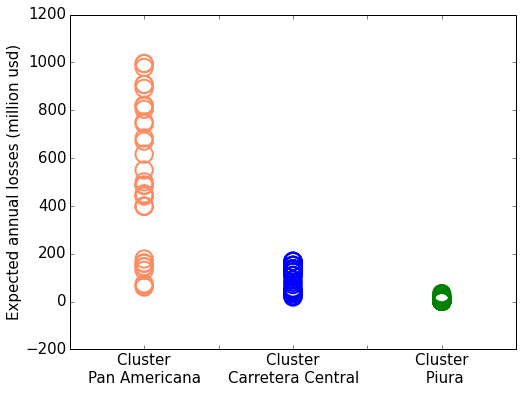

In [198]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

ax.scatter([0]*len(panam.exp_annual_losses),panam.exp_annual_losses*10**(-6),\
                 marker='o',s=300,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([1]*len(central.exp_annual_losses),central.exp_annual_losses*10**(-6),\
                 marker='o',s=300,facecolors='none',edgecolors='blue',linewidth='2')

ax.scatter([2]*len(norte.exp_annual_losses),norte.exp_annual_losses*10**(-6),\
                 marker='o',s=300,facecolors='none',edgecolors='green',linewidth='2')

ax.set_xlim([-0.5,2.5])
#ax.set_ylim([0,150])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Cluster \nPan Americana"
labelsx[3]="Cluster \nCarretera Central"
labelsx[5]="Cluster \n Piura"

ax.set_xticklabels(labelsx)

plt.ylabel("Expected annual losses (million usd)")

plt.savefig(figures+"EL_with_expost_intervention.png",bbox_inches="tight",dpi=100)

In [50]:
panam.exp_annual_losses.astype(float).describe()

count    3.600000e+01
mean     5.280170e+08
std      2.977938e+08
min      6.050132e+07
25%      3.428145e+08
50%      4.866745e+08
75%      8.069824e+08
max      9.957266e+08
Name: exp_annual_losses, dtype: float64

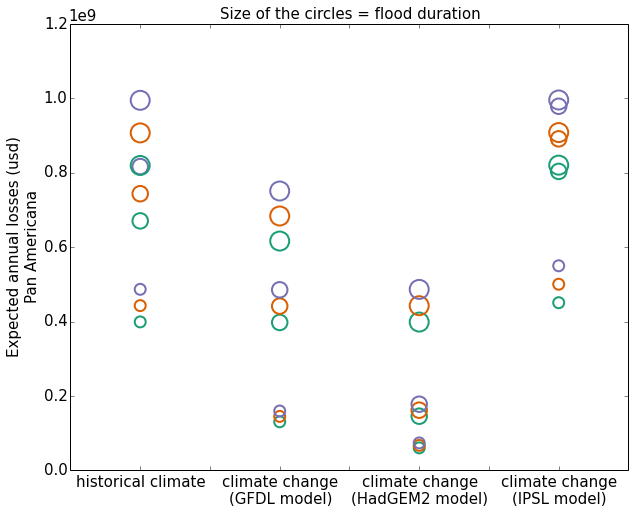

In [61]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)
j=0

sizes = [120*(i+1.) for i in range(3)]
labels = list()
for dur in ["optimistic","intermediate","pessimistic"]:
    labels.append("{} duration".format(dur))

for climat in ['EU_historical']:
    subout = panam.ix[panam.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),\
                   group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
        
for climat in ['GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    subout = panam.ix[panam.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
    
labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="historical climate"
labelsx[3]="climate change\n(GFDL model)"
labelsx[5]="climate change\n(HadGEM2 model)"
labelsx[7]="climate change\n(IPSL model)"

ax.set_xticklabels(labelsx)

plt.title("Size of the circles = flood duration",size=15)
plt.ylabel("Expected annual losses (usd) \nPan Americana")

#plt.savefig("results_418.png",bbox_inches="tight",dpi=400)

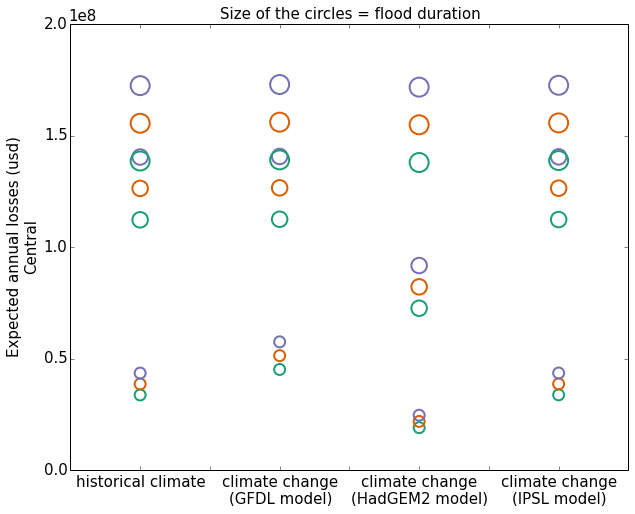

In [62]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)
j=0

sizes = [120*(i+1.) for i in range(3)]
labels = list()
for dur in ["optimistic","intermediate","pessimistic"]:
    labels.append("{} duration".format(dur))

for climat in ['EU_historical']:
    subout = central.ix[central.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),\
                   group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
        
for climat in ['GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    subout = central.ix[central.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
    
labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="historical climate"
labelsx[3]="climate change\n(GFDL model)"
labelsx[5]="climate change\n(HadGEM2 model)"
labelsx[7]="climate change\n(IPSL model)"

ax.set_xticklabels(labelsx)

plt.title("Size of the circles = flood duration",size=15)
plt.ylabel("Expected annual losses (usd)\nCentral")

#plt.savefig("results_418.png",bbox_inches="tight",dpi=400)

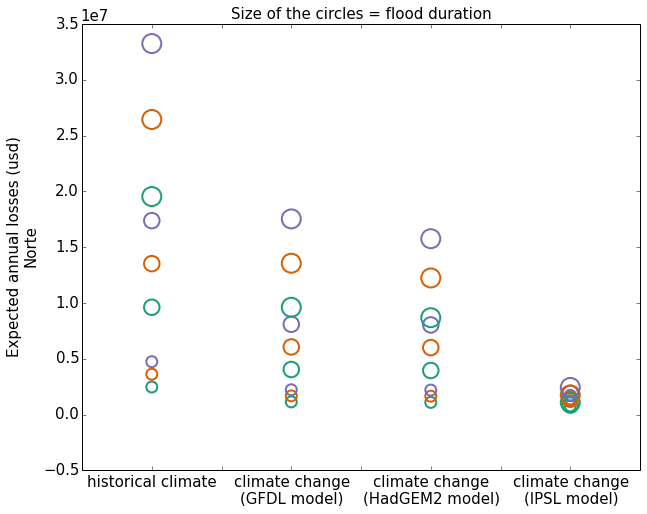

In [64]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)
j=0

sizes = [120*(i+1.) for i in range(3)]
labels = list()
for dur in ["optimistic","intermediate","pessimistic"]:
    labels.append("{} duration".format(dur))

for climat in ['EU_historical']:
    subout = norte.ix[norte.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),\
                   group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
        
for climat in ['GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    subout = norte.ix[norte.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
    
labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="historical climate"
labelsx[3]="climate change\n(GFDL model)"
labelsx[5]="climate change\n(HadGEM2 model)"
labelsx[7]="climate change\n(IPSL model)"

ax.set_xticklabels(labelsx)

plt.title("Size of the circles = flood duration",size=15)
plt.ylabel("Expected annual losses (usd)\nNorte")

#plt.savefig("results_418.png",bbox_inches="tight",dpi=400)